# Inert Doublet Model (IDM)

Excerpt from IDM_scan.ipynb, containing only the code to generate the k_ZH_240 vs k_ZH_365 plots

In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rc("axes",labelsize="large")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600

import os
os.chdir('/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections/')
# os.getcwd()

In [13]:
def read_IDM_file(df, loop_order=1):

    kappas = {}
    EWPOs = {}

    for fermion in ['uu', 'dd', 'ss', 'cc', 'bb', 'tt', 'ee', 'mumu', 'tautau']:
        kappas[fermion] = df['dkappaf'] + 1

    # kappas['gg'] = df['dkappaf'] + 1
    kappas['ZZ_0'] = df['effZZh1L_s0'] + df['effZZh1Lkala_s0'] + 1
    kappas['ZZ_125'] = df['effZZh1L_s125'] + df['effZZh1Lkala_s125'] + 1
    kappas['ZZ_240'] = df['effZZh1L_s240'] + df['effZZh1Lkala_s240'] + 1
    kappas['ZZ_365'] = df['effZZh1L_s365'] + df['effZZh1Lkala_s365'] + 1
    kappas['ZZ_500'] = df['effZZh1L_s500'] + df['effZZh1Lkala_s500'] + 1
    kappas['ZZ_550'] = df['effZZh1L_s550'] + df['effZZh1Lkala_s550'] + 1

    kappas['ZZ'] = df['dghZZ1L'] + 1
    kappas['WW'] = kappas['ZZ']


    if loop_order==1:
        kappas["lam"] = df['kalam1L']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam1L'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW1L']
        EWPOs['sin2thetaEff'] = df['sl1L']
        EWPOs['GammaZ'] = df['GamZ1L']

    elif loop_order==2:
        kappas["lam"] = df['kalam2LDI']

        kappas['gamgam'] = np.sqrt(df['DeltaGammagamgam2LDI'] + 1)
        kappas['Zgam'] = np.sqrt(df['DeltaGammaZgam1L'] + 1)

        EWPOs['Mw'] = df['MW2L']
        EWPOs['sin2thetaEff'] = df['sl2L']
        EWPOs['GammaZ'] = df['GamZ2L']

    else:
        raise ValueError("Wrong loop order argument!")

    return kappas, EWPOs


### Plot EffZZH[240] vs EffZZH[365]

In [14]:
def plot_EffZZH_240_vs_365(data_file, 
                           plot_dir, 
                           zoom=False, 
                           zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                           zoom_range_y=(0.0, 0.005),
                           modified_central=False,
                           plot_points=None,
                           BR_constraints=None,
                           ):
    
    df = pd.read_csv(data_file + ".csv")

    df = df.replace("", np.nan)
    df = df.dropna().reset_index(drop=True)
    n_pts = df.shape[0]
    n_pts_total = n_pts

    kappas, _ = read_IDM_file(df)
    if not BR_constraints is None:

        satisfy_BR_constraint = [True for i in range(n_pts)]
        for i in range(n_pts):
            for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                    satisfy_BR_constraint[i] = False

        for coup in kappas.keys():
            kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])

        n_pts_BR_constraint = len(kappas['ZZ'])
        print(f"Number of points satisfying the {BR_constraints*100:.3g}% SM constraint on the single higgs couplings: {n_pts_BR_constraint} / {n_pts}")

        n_pts = n_pts_BR_constraint

    
    color = np.array(kappas['lam'])  ## Color code is now kappa_lambda

    if BR_constraints is None:
        x_data = kappas['ZZ_365'].to_numpy() - 1
        y_data = kappas['ZZ_240'].to_numpy() - 1
    else:
        x_data = kappas['ZZ_365'] - 1
        y_data = kappas['ZZ_240'] - 1


    fig, ax = plt.subplots(
        figsize=(4.5, 4.),
        constrained_layout=True)

    color_map = mpl.colormaps['tab20c']

    sc = ax.scatter(
        x_data,
        y_data,
        c=color,
        s=0.4,
        cmap=color_map,
        rasterized=True)

    if zoom==True:
        ax.set_xlim(*zoom_range_x)
        ax.set_ylim(*zoom_range_y)

    clb = fig.colorbar(
        sc,
        ax=ax,
        label=r"$\kappa_\lambda$",
        pad=0,
        fraction=0.1,
        location='right',
        aspect=40,
        extend='max',
    )
    clb.ax.minorticks_on()


    ax.set_xlabel(r'$\kappa_{Z}^{365} - 1$')
    ax.set_ylabel(r'$\kappa_{Z}^{240} - 1$')


    lower_text = r'Inert Doublet Model'

    if BR_constraints:
        lower_text = lower_text + f"\n{BR_constraints*100:.3g}% SM constraints"
        lower_text = lower_text + f"\n{n_pts_BR_constraint} / {n_pts_total} Points"

    else:
        lower_text = lower_text + f'\n{n_pts} Points'+'\n'
    

    ax.text(
        0.97,
        0.05,
        lower_text,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=8
        )

    ax.text(
        0,
        1,
        r"$\mathrm{HiggsSignals}$",
        horizontalalignment="left",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    if modified_central: text_collider = "FCC-ee$_{{365}}$ Projections"
    else: text_collider = "FCC-ee$_{{365}}$ + HL-LHC Projections"
    ax.text(
        1,
        1,
        text_collider,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    

    if not plot_points is None:

        leg_handles = []
        legend_loc='upper left'

        color = ["tab:blue", "tab:orange"]
        
        colors = mpl.colormaps['tab20b']
        color = color + list(colors(np.linspace(0.001, 0.999, 20)[::-1]))
        for i, plot_point in enumerate(plot_points):

            ax.plot(*(plot_point[:2]), marker="*", ls="none", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5)
            point_label = f"{plot_point[2]}"
            leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5, label=point_label))
            

        hsLegend = ax.legend(
            handles=leg_handles,
            loc=legend_loc,
            frameon=False,
            prop={'size': 6},
            ncol=2,
        )
        ax.add_artist(hsLegend)


    if BR_constraints:
        plot_name = f'IDM_results_EffZZH_240_vs_365_{BR_constraints:.3g}_SM_constraints'
    else:
        plot_name = f'IDM_results_EffZZH_240_vs_365'

    if not (plot_points is None):
        plot_name = plot_name + "_BPs"
    if zoom: plot_name = plot_name + "_zoom"
    plt.savefig(f'{plot_dir}/{plot_name}'+".pdf")

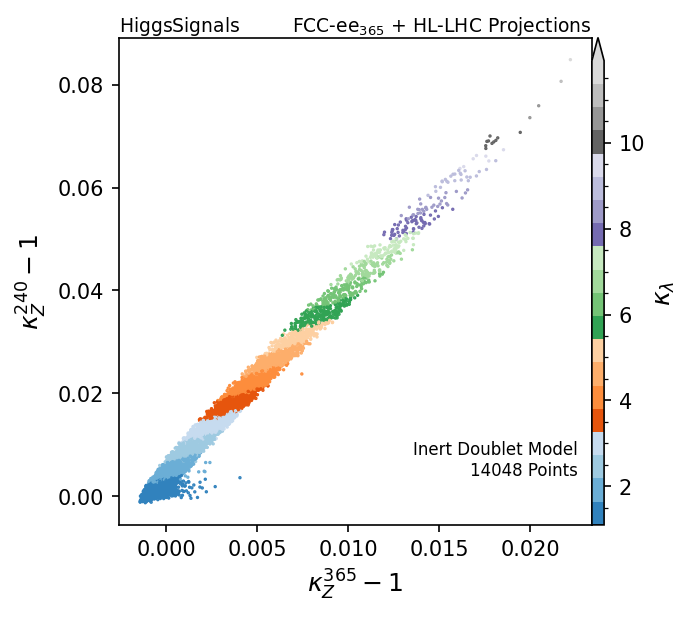

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
plot_EffZZH_240_vs_365(data_file, plot_dir)

Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


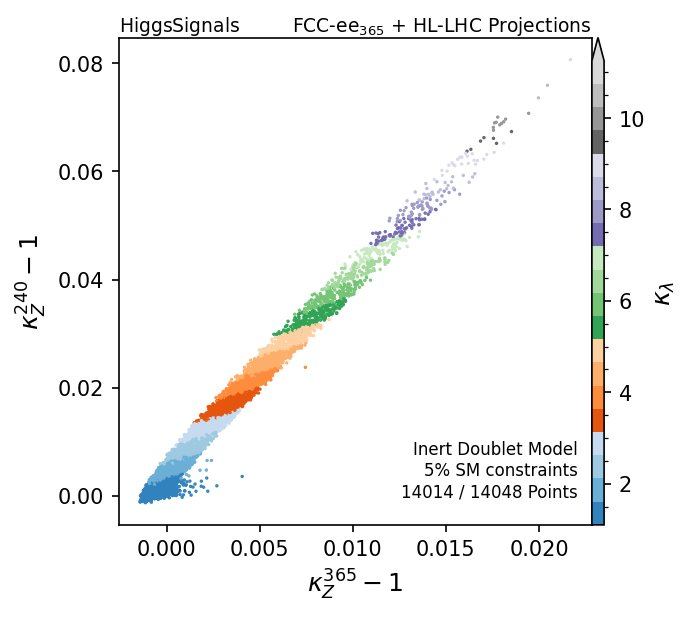

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_EffZZH_240_vs_365(data_file, plot_dir, 
                       BR_constraints=BR_constraints
                )

Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


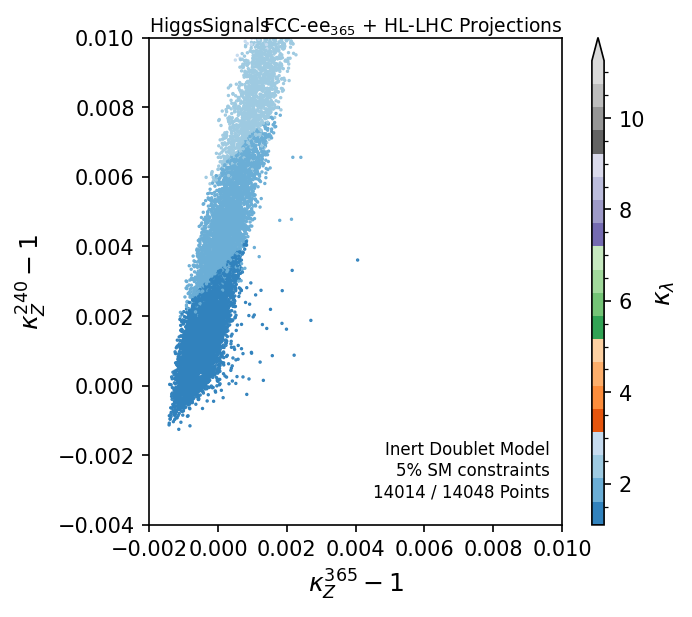

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints,
                       zoom=True,
                       zoom_range_x=(-0.002, 0.01), 
                       zoom_range_y=(-0.004, 0.01),
                )

Number of points satisfying the 1% SM constraint on the single higgs couplings: 533 / 14048


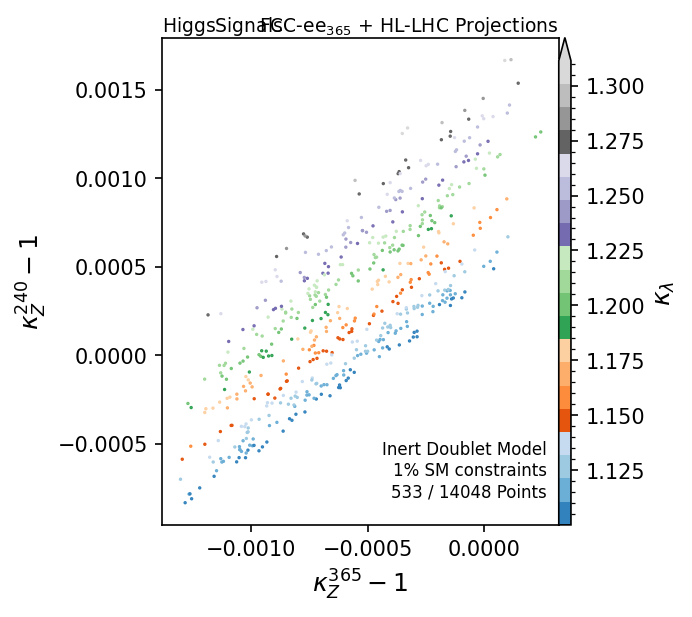

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.01
plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints
                )

### Finding Outlier Points 

In [19]:
import subprocess

In [ ]:
full=True
data_file="data/IDM/allIDMpoints_2025-01-14"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)
old_df_indices = df.iloc[:, 0].to_numpy()

kappas, EWPOs = read_IDM_file(df)

def print_to_file(message, file):
    print(message)
    print(message, file=file)

def find_benchmark(BP_Names,
                   BP_output_file,
                   max_errors_365,
                   max_errors_240,
                   delta_kappas_z_365,
                   delta_kappas_z_240,
                   ):


    n_pts = df.shape[0]
    chisq = np.full((n_pts,), np.nan)
    delta_kZ_240_365 = np.full((n_pts,), np.nan)
        

    if not len(delta_kappas_z_365) == len(delta_kappas_z_240):
        raise ValueError("delta_kappas_z_365 and delta_kappas_z_240 have different lengths!")

    bp_indices = [None for i in range(len(delta_kappas_z_365))]
    bp_kappas = [None for i in range(len(delta_kappas_z_365))]
    bp_EWPOs = [None for i in range(len(delta_kappas_z_365))]

    for ind, (kZ_365, kZ_240) in enumerate(zip(kappas['ZZ_365'], kappas['ZZ_240'])):
        for BP, (delta_kappa_z_365, delta_kappa_z_240, max_error_365, max_error_240) in enumerate(zip(delta_kappas_z_365, delta_kappas_z_240, max_errors_365, max_errors_240)):
            if abs((kZ_365-1) - delta_kappa_z_365) < max_error_365 and abs((kZ_240-1) - delta_kappa_z_240) < max_error_240:
                bp_indices[BP] = ind


    if any(bp_index is None for bp_index in bp_indices):
        missing_BPs = [i for i, bp_index in enumerate(bp_indices) if bp_index is None]
        raise ValueError(f"The following BPs were not found: {missing_BPs}")


    for BP, bp_index in enumerate(bp_indices):

        print_to_file(f"\nelif BP == \"{BP_Names[BP]}\":", file=BP_output_file)

        bp_kappas[BP] = {coup:kps[bp_index] for (coup, kps) in kappas.items()}
        bp_EWPOs[BP] = {obs_name:obs_value[bp_index] for (obs_name, obs_value) in EWPOs.items()}

        for coup, kaps in bp_kappas[BP].items():
            print_to_file(f"    kappas['{coup}'] = {kaps}", file=BP_output_file)

        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])/(bp_kappas[BP]['ZZ_240'] - 1))}", file=BP_output_file)
        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = {np.abs(bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])}", file=BP_output_file)

        for obs_name, obs_value in bp_EWPOs[BP].items():
            print_to_file(f"    {obs_name} = {obs_value}", file=BP_output_file)

        print_to_file(f"    # Best scan point row: {old_df_indices[bp_index]+2} out of {len(old_df_indices)+2}", file=BP_output_file)

        if delta_kZ_240_365[bp_index] == np.inf: 
            raise ValueError("Could not find point satisfying the constraints!")
        
    return bp_kappas


output_dir = "./scan_output/IDM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [1e-3, 1e-3, 1e-3, 1e-3, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 4e-4, 4e-4, 4e-4]
    max_errors_240 = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 2e-3, 2e-3, 2e-3]
    delta_kappas_z_365 = [0.0075, 0.004, -0.0024, 0.001, 0.0001, 0.0024, 0.0017, 0.0046, 0.0040, 0.0068, 0.0063, 0.0092, 0.0086, 0.0116, 0.011, 0.0140, 0.0140, 0.0165, 0.0164, 0.0195, 0.022]
    delta_kappas_z_240 = [0.023, 0.004, -0.0020, -0.0005, 0.008, 0.009, 0.016, 0.017, 0.0225, 0.025, 0.0325, 0.033, 0.040, 0.041, 0.049, 0.051, 0.058, 0.060, 0.066, 0.071, 0.08]



    BP_Names = ["BPO_0", "BPO_1"]
    BP_Names = BP_Names + [f"BPB_{i}" for i in range(len(delta_kappas_z_240)-2)]
    BP_Names_legend = ["BPO 0", "BPO 1"]
    BP_Names_legend = BP_Names_legend + [f"BPB {i}" for i in range(len(delta_kappas_z_240)-2)]

    bp_kappas = find_benchmark(BP_Names,
                               BP_output_file,
                               max_errors_365=max_errors_365,
                               max_errors_240=max_errors_240,
                               delta_kappas_z_365=delta_kappas_z_365,
                               delta_kappas_z_240=delta_kappas_z_240,
                              )


elif BP == "BPO_0":
    kappas['uu'] = 0.9818547810617284
    kappas['dd'] = 0.9818547810617284
    kappas['ss'] = 0.9818547810617284
    kappas['cc'] = 0.9818547810617284
    kappas['bb'] = 0.9818547810617284
    kappas['tt'] = 0.9818547810617284
    kappas['ee'] = 0.9818547810617284
    kappas['mumu'] = 0.9818547810617284
    kappas['tautau'] = 0.9818547810617284
    kappas['ZZ_0'] = 1.007141704579298
    kappas['ZZ_125'] = 1.0101170194271223
    kappas['ZZ_240'] = 1.0237693288776533
    kappas['ZZ_365'] = 1.0074536101415776
    kappas['ZZ_500'] = 1.0026988104523176
    kappas['ZZ_550'] = 1.0021232678597285
    kappas['ZZ'] = 0.9899392240917029
    kappas['WW'] = 0.9899392240917029
    kappas['lam'] = 4.038636858901748
    kappas['gamgam'] = 0.9514322699531608
    kappas['Zgam'] = 0.9820015140523058
    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.6864189906268178
    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = 0.016315718736075624
    Mw = 80.3586380016363

### Plotting the obtained points

Number of points satisfying the 5% SM constraint on the single higgs couplings: 14014 / 14048


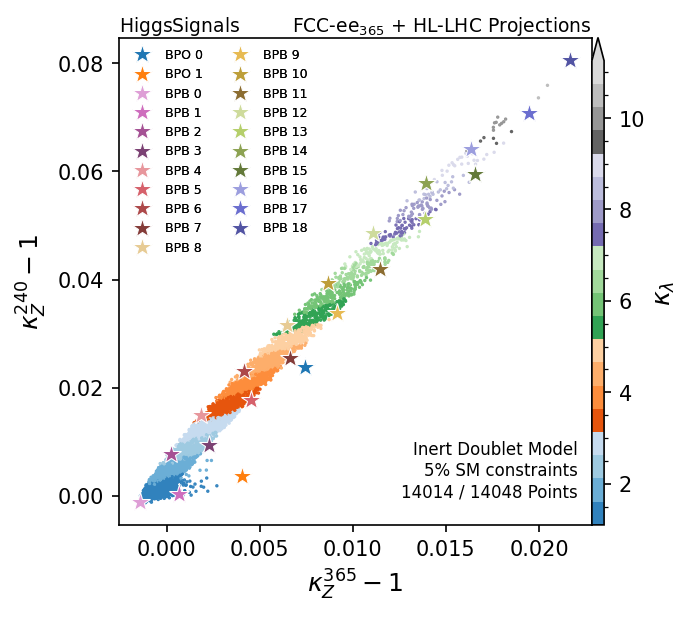

In [ ]:
data_file = "data/IDM/allIDMpoints_2025-01-14"
plot_dir = "plots/IDM"
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas, BP_Names_legend)]

plot_EffZZH_240_vs_365(data_file, plot_dir,
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                )